<a href="https://colab.research.google.com/github/KevinSikorskiBase2S/machine-learning-intro-workshop/blob/master/LatentMike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make a morph movie

This notebook is a mashum of the GameOfThronesStyleGAN and LatentMe notebooks and done by Kevin Sikorski.  The resources in those notebooks (and StyleGAN) are leveraged here, and so due credit is due to the people who wrote the notebooks those are derived from.


Let's start by downloading and setting up our GAN.

In [1]:
!git clone https://github.com/Puzer/stylegan

Cloning into 'stylegan'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 10.39 MiB | 26.32 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
%cd stylegan
# Use the version this notebook was built with
!git checkout c3fb250c65840c8837ded78e34485227755c2473

/content/stylegan
Note: checking out 'c3fb250c65840c8837ded78e34485227755c2473'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at c3fb250 Update README.md


In [0]:
!mkdir raw_images aligned_images generated_images latent_representations

## Add your image(s)

There are two ways to do this: 
- Use the canned images: this is easier and faster, and gives you the morph from Lionel to Mike to Bob to Mike.  This is what this notebook is setup up for if you don't change anything.
- Use your own images.  You'll have to read more closely, and comment out/uncomment some code to accomplish this.  Don't be afraid, if you are vaguely not incompetent, you'll do fine.  Probably.

### To use your own images...
Upload your image using the Sidebar now. 

To open the sidebar select "View" and then "Table of Contents".

The sidebar should now be open. Click the "Files" tab.

Before uploading make sure:

1.   The image(s) you're using can be opened by PIL (jpg, png, etc)
2.   The images are larger than 1024x1024. Preferably significantly larger so the aligner can crop out a high resolution section of the image containing your face.
3.   Your face in the image is well lit and facing the camera (for best results)

Click ''Upload" in the sidebar and select the images you want to upload from your computer.

Note: All files uploaded in this manner end up in the root of the file tree. We'll move them into the correct spot next.

In [0]:
# e.g. mv ../me.jpg raw_images/
#!mv ../Bob.jpg raw_images/
#!mv ../Mike.jpg raw_images/
#!mv ../lionel.jpg raw_images/

### Or use the canned images

Just download some canned images and we can use them.  Bob Ross, Lionel Richie, and Mike Haldeman have been graciously volunteered.



In [5]:
!git clone https://github.com/KevinSikorskiBase2S/machine-learning-intro-workshop
!cp machine-learning-intro-workshop/images/isItMeYourLookingFor/*.jpg raw_images

Cloning into 'machine-learning-intro-workshop'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 57 (delta 17), reused 32 (delta 4), pack-reused 0
Unpacking objects: 100% (57/57), done.


## Align your images
Do this IF you supplied your own image.  If you used the canned ones, skip this step.  This takes about 1-2 minutes per image.

In [0]:
#!python align_images.py raw_images aligned_images

This should produce an image in `aligned_images/` for every image in `raw_images/`.

It's a good idea to check that this process worked by using the Files browser to download each aligned image and make sure it looks reasonable. If you encounter scrambled images it might be because your original raw images are too small.

## Search for your latent self

Do this IF you supplied your own image.  If you used the canned ones, skip this step.  This takes about 5 minutes per image.

The script `encode_images.py` will minimize the perceptual loss between generated images from StyleGAN and each of the images you've uploaded. (By default this happens one at a time)

I've had good results at 1000 iterations and it's best to check the general quality before coming back and ramping up the number of iterations to produce a high-quality latent.

Higher quality comes at a cost of course. 10000 iterations will take about **one hour** for one image.

**NOTE:** You may get a warning about the GPU memory limit when running this script. Don't worry it will still complete.

In [0]:
#!python encode_images.py aligned_images/ generated_images/ latent_representations/ --iterations 1000

## Download Your Results

After the above cell has finished writing there should be an image in `generated_images/` for each image in `aligned_images/`.

You can right-click and download each of these images to see your final latent self.

### Latent Representation

You can also download the `npy` files in the `latent_representations/` directory. Each of those is a serialized numpy array which contains the (18, 512) array encoding the point in latent space which corresponds to the generated image. Which you can open with `latent = np.load('filename.npy')`

If you used the canned images (Bob, Mike, Lionel), then you need to copy the corresponding canned latent representations...

In [0]:
!cp machine-learning-intro-workshop/images/isItMeYourLookingFor/*.npy latent_representations

...and load them into memory:

In [0]:
# Loading already learned representations
lionelRep = np.load('latent_representations/lionel_01.npy')
mikeRep = np.load('latent_representations/Mike_01.npy')
bobRep = np.load('latent_representations/Bob_01.npy')

### Change your Smile, Gender, or Age

Once your latent representation has been generated and saved you can explore the volume around it through latent vectors. Puzer has provided vectors for Smile, Gender and Age so you can see what you look like as your latent self varies along those axes.

Run the following cells.

In [9]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [0]:
# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

# In general it's possible to find directions of almost any face attributes: position, hair style or color ... 
# Additional scripts for doing so will be realised soon

# Smile transformation

These next 3 sections have nothing to do with making the morph, I just wanted to see Lionel smile, and Bob Ross as a woman.  Because why not?

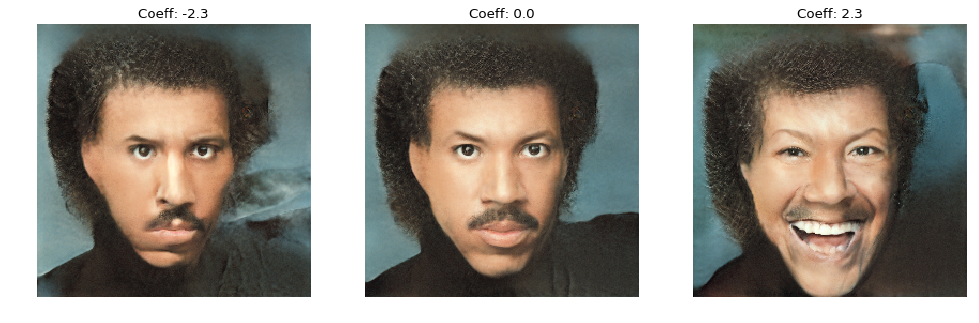

In [14]:
move_and_show(lionelRep, smile_direction, [-2.3, 0, 2.3])

# Gender transformation

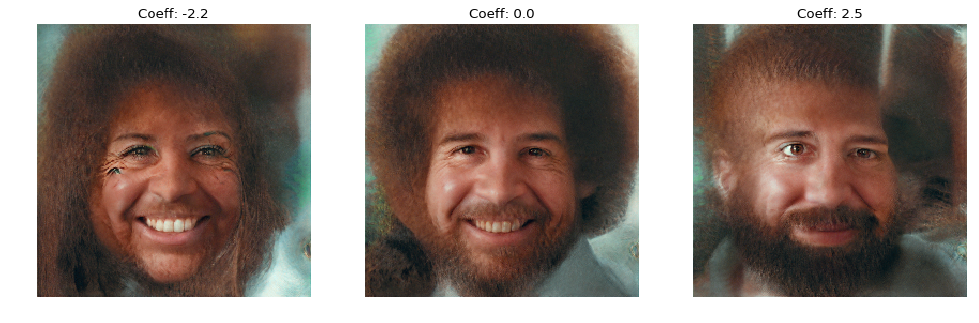

In [15]:
move_and_show(bobRep, gender_direction, [-2.2, 0, 2.5])

# Age transformation

Apparently old people wear glasses a lot.

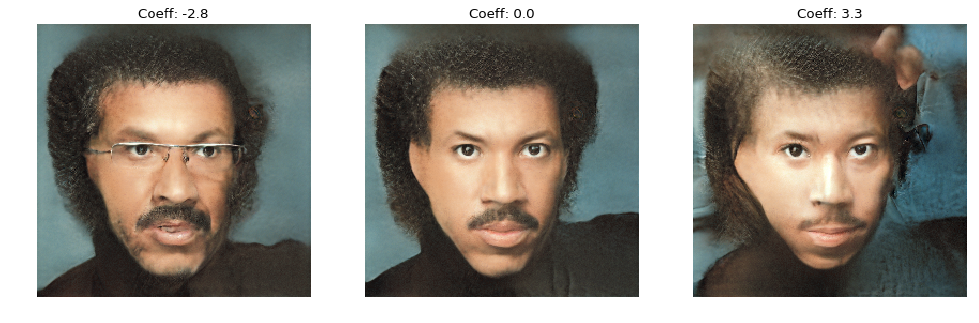

In [16]:
move_and_show(lionelRep, age_direction, [-2.8, 0, 3.3])

# Morph Movie happens below

We shall morph from Lionel to Mike to Bob to Mike.

Some movie parameters...

In [0]:
duration_sec = 15.0
smoothing_sec = 1.0
mp4_fps = 20
num_frames = int(np.rint(duration_sec * mp4_fps))

Define a couple helper functions.

In [0]:
def generate_image_for_video(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]

    return img_array
  
  
def move_for_video(latent_vector, direction, coeff):
  
  new_latent_vector = latent_vector.copy()
  new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
  
  img_array = generate_image(new_latent_vector)
  
  return img_array

We need a directory to collect our output in.

In [0]:
!mkdir results

Let's define a function for mixing latent vectors based on what frame we are on.  This is where the simple interpolation happens.

In [0]:
def get_latent_mix(alpha):
  coeff = (alpha%100)*0.01
  seg=int(alpha/100)
  if (seg==0):
    leftChar=lionelRep
    rightChar=mikeRep
  if (seg==1):
    leftChar=mikeRep
    rightChar=bobRep
  if (seg==2):
    leftChar=bobRep
    rightChar=mikeRep
  return (1-coeff)*leftChar + coeff*rightChar


A simple test mixing Mike and Bob at around 50% each.

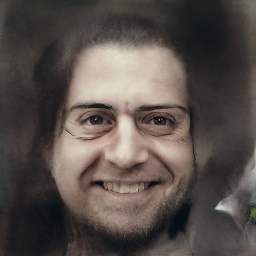

In [21]:
generate_image(get_latent_mix(255))

Oh that's beautiful.

Let's make a movie of the whole transformation.  When it's done, download the movie on the left bar, under the Files tab.  You should see interpolate.mp4 under stylegan/results/.  Double click it.

In [22]:

# This creates an nd array that stores all the image frames fot cross-character interpolation
src_images = np.stack(generate_image_for_video(get_latent_mix(alpha)) for alpha in range (300))

def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    src_image = src_images[frame_idx]
    return np.array(src_image)

# Generate video.
import moviepy.editor
mp4_file = 'results/interpolate.mp4'
mp4_codec = 'libx264'
mp4_bitrate = '5M'

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2457600/45929032 bytes (5.4%)6086656/45929032 bytes (13.3%)9756672/45929032 bytes (21.2%)13598720/45929032 bytes (29.6%)17399808/45929032 bytes (37.9%)21151744/45929032 bytes (46.1%)24928256/45929032 bytes (54.3%)28819456/45929032 bytes (62.7%)32645120/45929032 bytes (71.1%)36274176/45929032 bytes (79.0%)40132608/45929032 bytes (87.4%)44015616/45929032 bytes (95.8%)

100%|█████████▉| 300/301 [00:26<00:00,  9.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/interpolate.mp4 

